#### **PyTorch**

In [1]:
import torch
import torch.nn.functional as F
print(f"PyTorch Version: {torch.__version__}")

import torch
print(f"Cude is available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.2.2+cu121
Cude is available: True
Device name: NVIDIA A100-SXM4-40GB


#### **Import Other Libraries**

In [2]:
from datasets import load_dataset 
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
import numpy as np
import evaluate
from transformers import TrainingArguments
import torch 
import matplotlib.pyplot as plt 
from transformers import DataCollatorWithPadding
import os 
from pathlib import Path
import random 
from datasets import Dataset, DatasetDict
import warnings
from functools import partial
from datasets import concatenate_datasets
from functools import partial 
from tqdm import tqdm 
import textwrap
from IPython.display import display
from IPython.display import Markdown
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig
import os 
os.environ["WANDB_DISABLED"] = "true"
warnings.filterwarnings('ignore', message='Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.')

#### **Parameters**

In [3]:
# This cell is tagged with `parameters`
model_name = "google/gemma-1.1-7b-it" #microsoft/phi-2" #"microsoft/phi-2" #"#"meta-llama/Llama-2-7b-chat-hf" # "distilbert-base-uncased" 
column = 'text_with_prompt'
epochs = 1
seed = 0
verbose = False 
test_size = 0.5
p = 0.0

#### **Set Up Path**

In [4]:
results_folder = str(Path(os.getcwd()).parent.parent.absolute())  + '/results/'
figures_folder = str(Path(os.getcwd()).parent.parent.absolute())  + '/figures/'
print(results_folder)

/home/ubuntu/llmft/results/


In [5]:
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### ---         Memory Check
def Memory():
    print("Current memory usage:")
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
### ---

Memory()

Current memory usage:
Allocated: 0.0 GB
Cached:    0.0 GB


#### **Qlora**

In [8]:
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = True

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)
print(compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

peft_config = LoraConfig(
    r=32,
    lora_alpha=64,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules= ["Wqkv", "out_proj", "fc1", "fc2" ] # ["Wqkv", "out_proj", "fc1", "fc2" ], - 41M params
    # modules_to_save=["embed_tokens","lm_head"] 
)

torch.float16


#### **Instantiate Model**

In [9]:
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                             device_map="auto", 
                                             quantization_config=bnb_config, 
                                             trust_remote_code=True)# So we can do gradient checkpointing
print(model.generation_config)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}



In [10]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model.config.gradient_checkpointing = False


model = get_peft_model(model, peft_config)
print(model.print_trainable_parameters())
Memory()

trainable params: 26,214,400 || all params: 2,805,898,240 || trainable%: 0.9342605382581515
None
Current memory usage:
Allocated: 0.3 GB
Cached:    0.3 GB


#### **Instantiate Tokenizer**

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id 
tokenizer.padding_side="right"
model.config.pad_token_id = tokenizer.eos_token_id # ****I DON'T KNOW WHY WE NEED THIS??***



def formatting_prompts_func(example):
    # Create a list to store the formatted texts for each item in the example
    formatted_texts = []

    # Iterate through each example in the batch
    for text, raw_label in zip(example[column], example['raw_label']):
        # Format each example as a prompt-response pair
        formatted_text = f"{text} {raw_label}"
        formatted_texts.append(formatted_text)

    # Return the list of formatted texts
    return formatted_texts

def single_prompt(example):
    return f"{example[column]} {example['raw_label']}"


def formatting_prompts_func_dict(example):
    formatted_texts = []
    for text, raw_label in zip(example[column], example['raw_label']):
        formatted_text = f"{text} "
        formatted_texts.append(formatted_text)
    return {'formatted_texts': formatted_texts}

response_template_with_context = "\n\n    Answer:"  # We added context here: "\n". This is enough for this tokenizer
response_template_ids = tokenizer.encode(response_template_with_context, add_special_tokens=False) # Now we have it like in the dataset texts: `[2277, 29937, 4007, 22137, 29901]`
data_collator = DataCollatorForCompletionOnlyLM(response_template_ids, tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### **Data set**

In [12]:
dataset = load_dataset(f"ppower1/synthetic_evict_{p}", split='train', download_mode="force_redownload")


# Reshuffle and split the combined dataset with a fixed seed
new_splits = dataset.train_test_split(test_size=test_size, seed=seed)  # adjust test_size as needed

# Create a new DatasetDict with the shuffled splits
reshuffled_dataset = DatasetDict({
    'train': new_splits['train'],
    'test': new_splits['test']
})


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/150 [00:00<?, ? examples/s]

### ****

In [13]:
if verbose:
    init_results = []
    for i in range(150):
        input_text = dataset[column][i]
        model_inputs = tokenizer(input_text, return_tensors='pt').to('cuda')
        greedy_output = model.generate(**model_inputs, max_new_tokens=2)
        output_text= tokenizer.decode(greedy_output[0], skip_special_tokens=True)
        prediction =  find_first_yes_or_no(output_text[len(input_text):])
        target =  dataset['raw_label'][i]
        status = prediction == target
        if not status:
            init_results.append(i)
        print(f" Iter: {i}  | Status: {status}  |   Prediction: {find_first_yes_or_no(output_text[len(input_text):])}   |   Target: {dataset['raw_label'][i]}")
    print(len(init_results)/150)

In [14]:
def get_training_args(num_epochs):
    return TrainingArguments(
    output_dir='./synth_evict',
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    gradient_checkpointing=False,
    gradient_accumulation_steps=4, 
    lr_scheduler_type='cosine', # NEW 
    warmup_ratio = 0.1 # NEW 
)

In [15]:
# To get the initial training loss
trainer = SFTTrainer(
    model,   
    args=get_training_args(epochs), 
    train_dataset=reshuffled_dataset['train'],
    eval_dataset=reshuffled_dataset['train'],
    formatting_func=formatting_prompts_func,
    data_collator=data_collator,
    )

init_train_eval = trainer.evaluate()
init_train_loss = init_train_eval['eval_loss']
print(f"Initial Training Loss: {init_train_loss:.4f}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/pharrington19/.pyenv/versions/3.10.0/envs/jmp_env/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:194: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

You're using a CodeGenTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ppower1. Use `wandb login --relogin` to force relogin


Initial Training Loss: 0.9375


In [16]:
from transformers import TrainerCallback



In [17]:
class LLMSampleCB(TrainerCallback):
    def __init__(self, trainer, test_dataset, num_samples=10):
        super().__init__()
        self.sample_dataset = test_dataset.select(range(num_samples))
        self.model, self.tokenizer = trainer.model, trainer.tokenizer
    
    def on_epoch_end(self, args, state, control, **kwargs):
        print("\nModel outputs at epoch end:\n")
        init_results = []
        for i in range(len(self.sample_dataset)):
            input_text = self.sample_dataset['formatted_texts'][i]
            model_inputs = self.tokenizer(input_text, return_tensors='pt').to('cuda')
            greedy_output = kwargs['model'].generate(**model_inputs, max_new_tokens=2)
            output_text= self.tokenizer.decode(greedy_output[0], skip_special_tokens=True)
            prediction =  find_first_yes_or_no(output_text[len(input_text):])
            target =  dataset['raw_label'][i]
            status = prediction == target
            if not status:
                init_results.append(i)
            print(f" Iter: {i}  | Status: {status}  |   Prediction: {find_first_yes_or_no(output_text[len(input_text):])}   |   Target: {dataset['raw_label'][i]}")
        print(len(init_results)/150)

In [18]:
# To get the initial training loss
trainer = SFTTrainer(
    model,   
    args=get_training_args(epochs), 
    train_dataset=reshuffled_dataset['train'],
    eval_dataset=reshuffled_dataset['test'],
    formatting_func=formatting_prompts_func,
    data_collator=data_collator,
)

init_eval_eval = trainer.evaluate()
init_eval_loss = init_eval_eval['eval_loss']
print(f"Initial Evaluation Loss: {init_eval_loss:.4f}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/pharrington19/.pyenv/versions/3.10.0/envs/jmp_env/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:194: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Initial Evaluation Loss: 1.0259


In [19]:
test_dataset = reshuffled_dataset.map(formatting_prompts_func_dict, batched=True)['test']
wandb_callback = LLMSampleCB(trainer, test_dataset, num_samples=10)
trainer.add_callback(wandb_callback)


Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

In [20]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss
0,0.744400,0.246928



Model outputs at epoch end:



/home/pharrington19/.pyenv/versions/3.10.0/envs/jmp_env/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


 Iter: 0  | Status: False  |   Prediction: None   |   Target: No
 Iter: 1  | Status: False  |   Prediction: None   |   Target: No
 Iter: 2  | Status: False  |   Prediction: None   |   Target: Yes
 Iter: 3  | Status: False  |   Prediction: None   |   Target: No
 Iter: 4  | Status: False  |   Prediction: None   |   Target: No
 Iter: 5  | Status: False  |   Prediction: None   |   Target: No
 Iter: 6  | Status: False  |   Prediction: None   |   Target: Yes
 Iter: 7  | Status: False  |   Prediction: None   |   Target: No
 Iter: 8  | Status: False  |   Prediction: None   |   Target: No
 Iter: 9  | Status: False  |   Prediction: None   |   Target: No
0.06666666666666667


TrainOutput(global_step=4, training_loss=0.7444037199020386, metrics={'train_runtime': 15.2296, 'train_samples_per_second': 4.925, 'train_steps_per_second': 0.263, 'total_flos': 230142049689600.0, 'train_loss': 0.7444037199020386, 'epoch': 0.84})

In [62]:
import torch
from torch.nn.functional import softmax

# Assuming `model` and `tokenizer` are already defined and configured for CUDA as in your setup

init_results = []
yes_token_id = tokenizer.encode('Yes', add_special_tokens=False)[0]  # Get token ID for 'Yes'

for i in range(150):
    input_text = dataset[column][i]
    model_inputs = tokenizer(input_text, return_tensors='pt').to('cuda')
    
    # Directly use the model for inference to get logits
    with torch.no_grad():
        outputs = model(**model_inputs, labels=model_inputs["input_ids"])
        logits = outputs.logits  # Assuming you want the logits for the last token for 'Yes'

    
    # Calculate log probabilities
    output_probs = softmax(logits[0, -1, :], dim=0)  # Log probabilities of the last token
    
    
    # Extract log probability of 'Yes'
    output_prob = output_probs[yes_token_id].item()  # Log prob of 'Yes'
    
    # Your existing logic to determine prediction, status, and whether to add to init_results
    greedy_output = model.generate(**model_inputs, max_new_tokens=2)
    output_text = tokenizer.decode(greedy_output[0], skip_special_tokens=True)
    prediction = find_first_yes_or_no(output_text[len(input_text):])
    target = dataset['raw_label'][i]
    if target == 'No':
        output_prob = 1 - output_prob
        value =  1.0 - torch.min(output_probs)
    else:
        value =  torch.max(output_probs)
    status = prediction == target

    if not status:
        init_results.append((i, output_prob))  # Append index and log prob of 'Yes'
    print(f"Iter: {i} | Max Prob: {value:.4f} | Prob : {output_prob:.4f} | Status: {status} | Prediction: {prediction} | Target: {target}")
    if i > 1 :
        break   
#print(len(init_results)/150)


Iter: 0 | Max Prob: 1.0000 | Prob : 0.9989 | Status: True | Prediction: No | Target: No
Iter: 1 | Max Prob: 1.0000 | Prob : 1.0000 | Status: True | Prediction: No | Target: No
Iter: 2 | Max Prob: 0.5126 | Prob : 0.0018 | Status: True | Prediction: Yes | Target: Yes


In [53]:
output_probs[yes_token_id]

tensor(0.0011, device='cuda:3')

In [51]:
torch.max(output_probs)

tensor(0.6862, device='cuda:3')

In [21]:
steps, train_loss = [0] + [i['step'] for i in trainer.state.log_history if 'loss' in i], [init_train_loss] + [i['loss'] for i in trainer.state.log_history if 'loss' in i]
_, eval_loss = [i['step'] for i in trainer.state.log_history if 'eval_loss' in i], [init_eval_loss] + [i['eval_loss'] for i in trainer.state.log_history if 'eval_loss' in i]

In [22]:
[i['learning_rate'] for i in trainer.state.log_history if 'learning_rate' in i]

[0.0]

In [23]:
eval_loss

[1.0258930921554565, 0.24692779779434204]

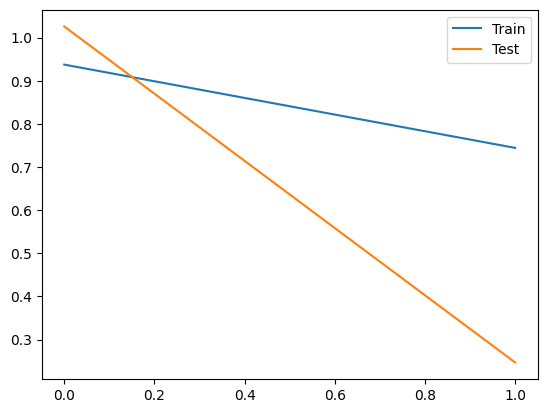

In [24]:
plt.plot(train_loss, label='Train')
plt.plot(eval_loss, label='Test')
plt.legend()
plt.show()

In [25]:
np.save(datafolder + f'synth_evict_steps_causalm.npy', np.array(steps))
np.save(datafolder + f'synth_evict_pred_train_loss_causalm_phi2_{column}_{seed}_{p}_{test_size}.npy', np.array(train_loss))
np.save(datafolder + f'synth_evict_pred_eval_loss_causalm_phi2_{column}_{seed}_{p}_{test_size}.npy', np.array(eval_loss))